# Import packages

In [229]:
import numpy as np
import pandas as pd
from itertools import chain
from pprint import pprint
from collections import Counter
from datetime import datetime, date, timedelta

import sqlite3
from pathlib import Path
import yaml
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud, ImageColorGenerator

In [166]:
#Topic modeling with LDA
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#For interactive graph:
import pyLDAvis.gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\U060419\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [295]:
#network
import networkx as nx

# Read data

In [303]:
path = Path('C:/Users/U060419/UCB/iPVU Web Scraping and trends - General/articles.db')

In [304]:
conn = sqlite3.connect('articles.db')
data = pd.read_sql("SELECT * FROM articles_unique",conn)
data.head()

,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words
0,DOI:10.1016/j.ando.2020.04.005,10.1016/j.ando.2020.04.005,Annales d'Endocrinologie,2020-04-21 00:00:00+00:00,ELSEVIER,"['renin-angiotensin-aldosterone', 'system', 'c...",['Abstract With multiplication COVID-19 severe...,"['abstract', 'with', 'multiplication', 'covid-..."
1,DOI:10.1016/j.jamda.2020.04.017,10.1016/j.jamda.2020.04.017,Journal of the American Medical Directors Asso...,2020-04-23 00:00:00+00:00,ELSEVIER,"['the', 'geriatrician', 'the', 'frontline', 's...","['Abstract On February 20 , 2020 , man live no...","['abstract', 'on', 'february', '20', '2020', '..."
2,DOI:10.1016/j.fertnstert.2020.04.025,10.1016/j.fertnstert.2020.04.025,Fertility and Sterility,2020-04-16 00:00:00+00:00,ELSEVIER,"['prior', 'novel', 'coronaviruses', 'covid-19'...",['Structured Abstract Objective To summarize c...,"['structured', 'abstract', 'objective', 'to', ..."
3,DOI:10.1016/j.neurol.2020.04.004,10.1016/j.neurol.2020.04.004,Revue Neurologique,2020-04-20 00:00:00+00:00,ELSEVIER,"['guidance', 'care', 'neuromuscular', 'patient...","['Abstract In France , epidemic phase COVID-19...","['abstract', 'in', 'france', 'epidemic', 'phas..."
4,DOI:10.1016/j.jtcvs.2020.04.059,10.1016/j.jtcvs.2020.04.059,The Journal of Thoracic and Cardiovascular Sur...,2020-04-27 00:00:00+00:00,ELSEVIER,"['adult', 'cardiac', 'surgery', 'covid-19', 'p...",['Abstract The COVID-19 pandemic necessitate a...,"['abstract', 'the', 'covid-19', 'pandemic', 'n..."


In [202]:
stop_words = stopwords.words('english')

In [203]:
with open(r'C:/Users/U060419/UCB/iPVU Web Scraping and trends - General/parameters.yml') as file:
    parameters = yaml.full_load(file)
    for param, values in parameters.items():
        print(param, ":", values)
    keywords = parameters.get('keywords')
    keywords.sort()
    stop_words.extend(parameters.get('stopwords'))

for keyword in keywords:
    keyword = keyword.strip()
    
for stopword in stop_words:
    stopword = stopword.strip()

keywords : ['brodalumab', 'kyntheum', 'ixekizumab', 'taltz', 'secukinumab', 'cosentyx', 'ustekinumab', 'stelara', 'guselkumab', 'tremfya', 'risankizumab', 'skyrizi', 'tildrakizumab', 'ilumetri', 'tocilizumab', 'roactemra', 'tofacitinib', 'rituximab', 'olimumab', 'xeljanz', 'mabthera', 'simponi', 'baracitinib', 'adalimumab', 'baricitinib', 'olumiant', 'humira', 'olumiant', 'apremilast', 'etanercept', 'upadacitinib', 'otezla', 'enbrel', 'rinvoq', 'abatacept', 'infliximab', 'certolizumab pegol', 'orencia', 'remicade', 'cimzia', 'methotrexate', 'mycophenolate mofetil', 'azathioprine', 'cyclophosphamide', 'chloroquine', 'tacrolimus', 'ciclosporin', 'global health emergency', 'hydroxychloroquine', 'leflunomide', 'infection', 'sulfasalazine', 'SARS-CoV-2', 'in vitro', 'safety', 'psoriasis', 'rheumatoid arthritis', 'psoriatic arthritis', 'ankylosing spondylitis', 'axial spondyloarthritis', 'spondyloarthritis', "crohn's disease", 'axial spondyloarthritis']
stopwords : ['from', 'subject', 're', 

In [301]:
#close connection
conn.close()

# Visualizations

## Number of publications per source

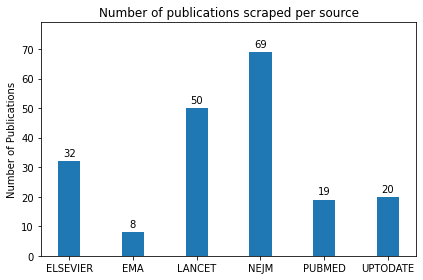

In [204]:
# TO DO - rewrite query for mydate
mydata = data.groupby(['Source']).count()
sources = mydata.index
counts = mydata.title_words

x = np.arange(len(sources))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, counts, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Publications')
ax.set_title('Number of publications scraped per source')
ax.set_xticks(x)
ax.set_xticklabels(sources)
ax.set_ylim([0, max(counts)+10])
# ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

fig.tight_layout()

plt.show()

## Wordcloud per publication

In [205]:
# TO DO: rewrite query + include title (or include title if publication is missing)
data_processed = data[['ID','PublishedDate','abstract_words']]
print('Number of missing values in publishedDate and/or abstract:\n'+str(data_processed.isna().sum()))
# data_ready_with_publicationDate.dropna(inplace=True)

import ast
def process_words(text, stop_words=stop_words):
    """Remove Stopwords"""
    text_out = []
    for word in ast.literal_eval(text):
        if word not in stop_words: 
            text_out.append(word)
    return text_out

data_processed['abstract_words'] = data_processed['abstract_words'].apply(lambda abstract: process_words(abstract))  # processed Text Data!

Number of missing values in publishedDate and/or abstract:
ID                 1
PublishedDate     55
abstract_words     0
dtype: int64


c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


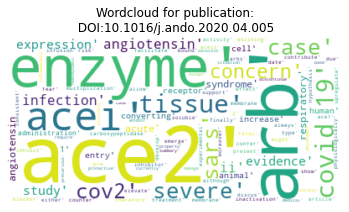

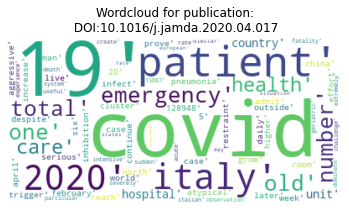

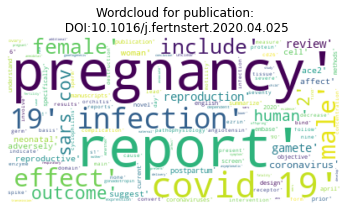

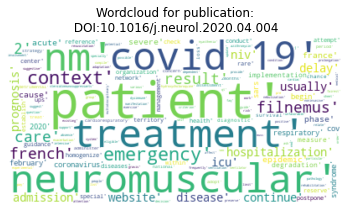

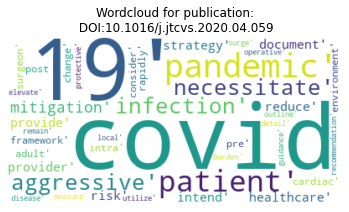

In [127]:
#TO DO: extract title instead of ID
#First 5 publications

for ID in data_processed[0:5]['ID']:
    publ = data_processed[data_processed['ID'] == ID]
    text = ' '.join([str(word) for word in publ['abstract_words']]) 

    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color="white").generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Wordcloud for publication:\n'+publ['ID'].to_string(index=False))
    plt.axis("off")
    plt.show()

## Keyword count for top 5 per publication (bar chart)

In [206]:
def try_parsing_date(text):
    if text == None:
        return None
    for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S+00:00', '%Y-%m-%d'):
        try:
            return datetime.strptime(text, fmt).date()
        except ValueError:
            pass
    raise ValueError('no valid date format found')

data_processed['PublishedDate'] = data_processed['PublishedDate'].apply(lambda x: try_parsing_date(x))

c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [207]:
data_with_keyword = data_processed
for keyword in keywords:
    data_with_keyword[keyword] = data_with_keyword['abstract_words'].apply(lambda x: x.count(keyword) if (keyword in x) 
                                                                           else 0)
    
data_with_keyword = data_with_keyword.groupby(['ID'],as_index=True).sum()
print(data_with_keyword)

                                                    SARS-CoV-2  abatacept  \
ID                                                                          
DOI:10.1007/s11547-020-01200-3                               0          0   
DOI:10.1016/S0140-6736(14)61202-2                            0          0   
DOI:10.1016/S0140-6736(20)30183-5                            0          0   
DOI:10.1016/S0140-6736(20)30460-8                            0          0   
DOI:10.1016/S0140-6736(20)30566-3                            0          0   
...                                                        ...        ...   
URL:emas-governance-during-covid-19-pandemic                 0          0   
URL:guidance-medicine-developers-companies-covi...           0          0   
URL:international-coalition-medicines-regulator...           0          0   
URL:public-health-advice-during-covid-19-pandemic            0          0   
URL:treatments-vaccines-covid-19                             0          0   

c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


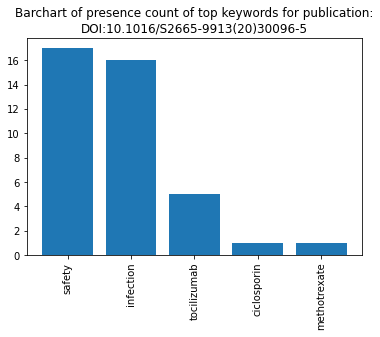

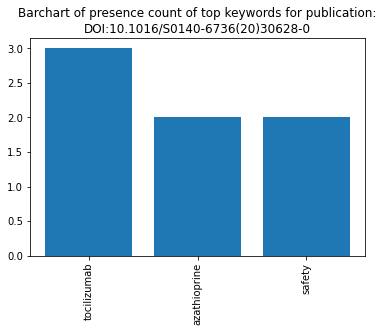

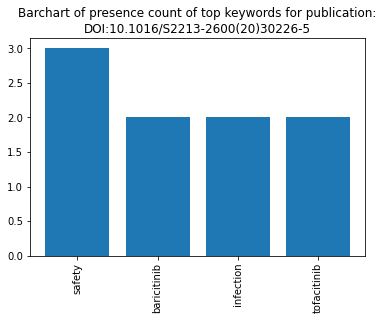

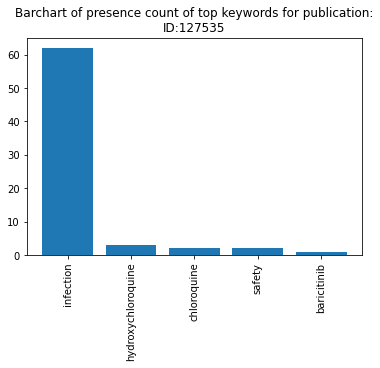

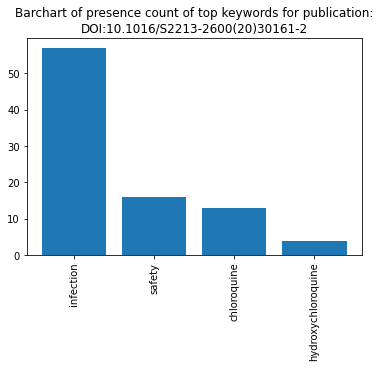

In [208]:
#First 5 publications

data_with_keyword.sort_values(by=keywords, ascending=False, inplace=True)

for ID in data_with_keyword[0:5].index:
    publ = data_with_keyword[data_with_keyword.index == ID]
    cnt = Counter(publ.iloc[:,3:].to_dict('r')[0])
    cnt += Counter()
    top_5 = cnt.most_common(5)  
    if len(top_5) == 0:
        continue
    terms = list(zip(*top_5))[0]
    counts = list(zip(*top_5))[1]
    plt.bar(range(len(counts)), counts, align='center')
    plt.xticks(range(len(terms)), terms)
    plt.title('Barchart of presence count of top keywords for publication:\n'+ID)
    plt.xticks(rotation=90)
    plt.show()
    

# Topic model with LDA

In [145]:
data_for_topics = data_processed['abstract_words']

In [146]:
#Build topic model

#parameters
n_topics = 5 #number of topics

# Create Dictionary
id2word = corpora.Dictionary(data_for_topics)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_for_topics]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

#### Topics:

In [147]:
pprint(lda_model.print_topics())

[(0,
  '0.030*"anakinra" + 0.022*"anesthesia" + 0.015*"machine" + '
  '0.013*"anesthetic" + 0.010*"juvenile" + 0.010*"idiopathic" + '
  '0.008*"rheumatol" + 0.008*"inhalation" + 0.008*"hlh" + 0.007*"ventilator"'),
 (1,
  '0.017*"syndrome" + 0.012*"et" + 0.012*"cytokine" + 0.010*"treatment" + '
  '0.009*"trial" + 0.009*"storm" + 0.007*"0" + 0.007*"systemic" + '
  '0.006*"intravenous" + 0.006*"evidence"'),
 (2,
  '0.033*"patient" + 0.032*"covid-19" + 0.016*"disease" + 0.012*"care" + '
  '0.012*"coronavirus" + 0.009*"2019" + 0.008*"infection" + 0.007*"clinical" + '
  '0.006*"include" + 0.006*"risk"'),
 (3,
  '0.016*"cancer" + 0.015*"dialysis" + 0.013*"mental" + 0.012*"aki" + '
  '0.011*"quarantine" + 0.007*"peritoneal" + 0.007*"psychological" + '
  '0.007*"disorder" + 0.006*"hemodialysis" + 0.006*"anxiety"'),
 (4,
  '0.015*"health" + 0.012*"2020" + 0.008*"covid-19" + 0.008*"international" + '
  '0.007*"et" + 0.007*"kingdom" + 0.007*"march" + 0.007*"april" + '
  '0.007*"access" + 0.006*"ur

#### Documents which match the topic the most for each topic:

In [148]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Topic Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_for_topics)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']

df_dominant_topic = df_dominant_topic.merge(data, how='left', left_index=True, right_index=True) #merge with abstract on index

for topic in range(n_topics):
    wp = lda_model.show_topic(topic)
    topic_keywords = ", ".join([word for word, prop in wp])
    print('Topic '+str(topic)+':\n')
    print('Keywords in topic: '+topic_keywords)
    display(df_dominant_topic.loc[df_dominant_topic['Dominant_Topic']==topic,:].sort_values(by='Topic_Perc_Contrib', ascending=False).head(5))

Topic 0:

Keywords in topic: anakinra, anesthesia, machine, anesthetic, juvenile, idiopathic, rheumatol, inhalation, hlh, ventilator


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words
139,139,0.0,0.5997,"anakinra, anesthesia, machine, anesthetic, juv...",[cmaj],DOI:10.1503/cmaj.200685,10.1503/cmaj.200685,CMAJ,2020-05-03 00:00:00,PUBMED,"['coagulopathy', 'associate', 'covid-19']",['CMAJ'],['cmaj']
146,146,0.0,0.5997,"anakinra, anesthesia, machine, anesthetic, juv...",[cmaj],DOI:10.1503/cmaj.200650,10.1503/cmaj.200650,CMAJ,2020-05-03 00:00:00,PUBMED,"['tracheal', 'intubation', 'patient', 'covid-19']",['CMAJ'],['cmaj']
140,140,0.0,0.5994,"anakinra, anesthesia, machine, anesthetic, juv...",[neoreviews],DOI:10.1542/neo.21-5-e293,10.1542/neo.21-5-e293,Neoreviews,2020-05-03 00:00:00,PUBMED,"['neonatal', 'management', 'during', 'coronavi...",['Neoreviews'],['neoreviews']
191,191,0.0,0.5492,"anakinra, anesthesia, machine, anesthetic, juv...","[j, coll, radiol]",DOI:10.1016/j.jacr.2020.04.019,10.1016/j.jacr.2020.04.019,J Am Coll Radiol,2020-05-04 00:00:00,PUBMED,"['touch', 'me', 'not', 'physical', 'distancing...",['J Am Coll Radiol'],"['j', 'am', 'coll', 'radiol']"
196,196,0.0,0.5492,"anakinra, anesthesia, machine, anesthetic, juv...","[j, coll, radiol]",DOI:10.1016/j.jacr.2020.04.025,10.1016/j.jacr.2020.04.025,J Am Coll Radiol,2020-05-04 00:00:00,PUBMED,"['coronavirus', 'disease', '2019', 'covid-19',...",['J Am Coll Radiol'],"['j', 'am', 'coll', 'radiol']"


Topic 1:

Keywords in topic: syndrome, et, cytokine, treatment, trial, storm, 0, systemic, intravenous, evidence


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words
0,0,1.0,0.7080,"syndrome, et, cytokine, treatment, trial, stor...","[multiplication, covid-19, severe, acute, resp...",DOI:10.1016/j.ando.2020.04.005,10.1016/j.ando.2020.04.005,Annales d'Endocrinologie,2020-04-21 00:00:00+00:00,ELSEVIER,"['renin-angiotensin-aldosterone', 'system', 'c...",['Abstract With multiplication COVID-19 severe...,"['abstract', 'with', 'multiplication', 'covid-..."
115,115,1.0,0.6393,"syndrome, et, cytokine, treatment, trial, stor...","[research, letter, investigator, report, stabi...",DOI:10.1056/NEJMc2004973,10.1056/NEJMc2004973,Correspondence,2020-04-16 00:00:00,NEJM,"['aerosol', 'surface', 'stability', 'sars-cov-2']","['In research letter , investigator report sta...","['in', 'research', 'letter', 'investigator', '..."
8,8,1.0,0.5966,"syndrome, et, cytokine, treatment, trial, stor...",[n],DOI:10.1016/j.jaci.2020.04.029,10.1016/j.jaci.2020.04.029,Journal of Allergy and Clinical Immunology,2020-04-29 00:00:00+00:00,ELSEVIER,"['type', 'i', 'ifn', 'immunoprofiling', 'covid...",None,"['n', 'a']"
63,63,1.0,0.5895,"syndrome, et, cytokine, treatment, trial, stor...","[cardiovascular, complication, rapidly, emerge...",DOI:10.1016/S0140-6736(20)30937-5,10.1016/S0140-6736(20)30937-5,Correspondence,None,LANCET,"['endothelial', 'cell', 'infection', 'endothel...",['Cardiovascular complication rapidly emerge k...,"['cardiovascular', 'complication', 'rapidly', ..."
182,182,1.0,0.5892,"syndrome, et, cytokine, treatment, trial, stor...","[coronavirus, disease, 2019, covid-19, pandemi...",DOI:10.1016/S2213-2600(20)30226-5,10.1016/S2213-2600(20)30226-5,Comment,None,LANCET,"['immunomodulation', 'covid-19']",['The coronavirus disease 2019 ( COVID-19 ) pa...,"['the', 'coronavirus', 'disease', '2019', 'cov..."


Topic 2:

Keywords in topic: patient, covid-19, disease, care, coronavirus, 2019, infection, clinical, include, risk


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words
6,6,2.0,0.9953,"patient, covid-19, disease, care, coronavirus,...","[background, data, available, rate, characteri...",DOI:10.1016/j.thromres.2020.04.024,10.1016/j.thromres.2020.04.024,Thrombosis Research,2020-04-23 00:00:00+00:00,ELSEVIER,"['venous', 'arterial', 'thromboembolic', 'comp...",['Abstract Background Few data available rate ...,"['abstract', 'background', 'few', 'data', 'ava..."
14,14,2.0,0.9940,"patient, covid-19, disease, care, coronavirus,...","[objective, acute, stroke, remain, medical, em...",DOI:10.1016/j.bbi.2020.04.077,10.1016/j.bbi.2020.04.077,"Brain, Behavior, and Immunity",2020-04-28 00:00:00+00:00,ELSEVIER,"['covid-19', 'present', 'stroke']",['Abstract Objective Acute stroke remain medic...,"['abstract', 'objective', 'acute', 'stroke', '..."
4,4,2.0,0.9812,"patient, covid-19, disease, care, coronavirus,...","[covid-19, pandemic, necessitate, aggressive, ...",DOI:10.1016/j.jtcvs.2020.04.059,10.1016/j.jtcvs.2020.04.059,The Journal of Thoracic and Cardiovascular Sur...,2020-04-27 00:00:00+00:00,ELSEVIER,"['adult', 'cardiac', 'surgery', 'covid-19', 'p...",['Abstract The COVID-19 pandemic necessitate a...,"['abstract', 'the', 'covid-19', 'pandemic', 'n..."
5,5,2.0,0.9812,"patient, covid-19, disease, care, coronavirus,...","[covid-19, pandemic, necessitate, aggressive, ...",DOI:10.1016/j.athoracsur.2020.04.007,10.1016/j.athoracsur.2020.04.007,The Annals of Thoracic Surgery,2020-04-27 00:00:00+00:00,ELSEVIER,"['adult', 'cardiac', 'surgery', 'covid-19', 'p...",['Abstract The COVID-19 pandemic necessitate a...,"['abstract', 'the', 'covid-19', 'pandemic', 'n..."
156,156,2.0,0.9808,"patient, covid-19, disease, care, coronavirus,...","[end, 2019, novel, coronavirus, identify, caus...",ID:127501,None,medical,2020-04-30 02:00:00,UPTODATE,"['coronavirus', 'disease', '2019', 'covid-19',...","['INTRODUCTION — At end 2019 , novel coronavir...","['introduction', 'at', 'end', '2019', 'novel',..."


Topic 3:

Keywords in topic: cancer, dialysis, mental, aki, quarantine, peritoneal, psychological, disorder, hemodialysis, anxiety


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words
143,143,3.0,0.5998,"cancer, dialysis, mental, aki, quarantine, per...",[bmj],DOI:10.1136/bmj.m1793,10.1136/bmj.m1793,BMJ,2020-05-03 00:00:00,PUBMED,"['covid-19', 'nhs', 'outline', 'service', 'pri...",['BMJ'],['bmj']
147,147,3.0,0.5998,"cancer, dialysis, mental, aki, quarantine, per...",[bmj],DOI:10.1136/bmj.m1725,10.1136/bmj.m1725,BMJ,2020-05-03 00:00:00,PUBMED,"['covid-19', 'doctor', 'must', 'take', 'contro...",['BMJ'],['bmj']
194,194,3.0,0.5997,"cancer, dialysis, mental, aki, quarantine, per...",[ophthalmology],DOI:10.1016/j.ophtha.2020.04.028,10.1016/j.ophtha.2020.04.028,Ophthalmology,2020-05-04 00:00:00,PUBMED,"['ocular', 'findings', 'proportion', 'conjunct...",['Ophthalmology'],['ophthalmology']
85,85,3.0,0.5593,"cancer, dialysis, mental, aki, quarantine, per...","[burnout, problem, solve, without, address, is...",DOI:10.1056/NEJMp2003149,10.1056/NEJMp2003149,Perspective,2020-05-01 00:00:00,NEJM,"['physician', 'burnout', 'interrupted']",['The burnout problem ’ solve without address ...,"['the', 'burnout', 'problem', 'solve', 'withou..."
98,98,3.0,0.5344,"cancer, dialysis, mental, aki, quarantine, per...","[harvey, fineberg, call, forceful, focus, camp...",DOI:10.1056/NEJMe2007263,10.1056/NEJMe2007263,Editorial,2020-04-23 00:00:00,NEJM,"['ten', 'weeks', 'crush', 'curve']","['Harvey Fineberg call forceful , focus campai...","['harvey', 'fineberg', 'call', 'forceful', 'fo..."


Topic 4:

Keywords in topic: health, 2020, covid-19, international, et, kingdom, march, april, access, urlplaceholder


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,ID,DOI,Type,PublishedDate,Source,title_words,abstract_sentences,abstract_words
12,12,4.0,0.8518,"health, 2020, covid-19, international, et, kin...","[rsum, le, de, cet, article, est, de, dtailler...",DOI:10.1016/j.jchirv.2020.04.009,10.1016/j.jchirv.2020.04.009,Journal de Chirurgie Viscérale,2020-04-18 00:00:00+00:00,ELSEVIER,"['gestion', 'de', 'l', 'pidmie', 'de', 'la', '...",['Résumé Le de cet article est de détailler le...,"['rsum', 'le', 'de', 'cet', 'article', 'est', ..."
42,42,4.0,0.7785,"health, 2020, covid-19, international, et, kin...","[criticise, nicaragua, response, coronavirus, ...",DOI:10.1016/S2214-109X(20)30218-7,10.1016/S2214-109X(20)30218-7,Correspondence,None,LANCET,"['nicaragua', 's', 'response', 'covid-19']","[""In criticise Nicaragua 's response coronavir...","['in', 'criticise', 'nicaragua', 's', 'respons..."
28,28,4.0,0.7658,"health, 2020, covid-19, international, et, kin...","[ema, endorse, joint, statement, member, inter...",URL:international-coalition-medicines-regulato...,None,Update,2020-04-28 00:00:00,EMA,"['international', 'coalition', 'medicines', 'r...",['EMA endorse joint statement member Internati...,"['ema', 'endorse', 'joint', 'statement', 'memb..."
40,40,4.0,0.7401,"health, 2020, covid-19, international, et, kin...","[2018, 22nd, international, aids, conference, ...",DOI:10.1016/S0140-6736(20)31026-6,10.1016/S0140-6736(20)31026-6,Comment,None,LANCET,"['a', 'covid-19', 'conference', 'aids', '2020'...","['In 2018 , 22nd International AIDS Conference...","['in', '2018', '22nd', 'international', 'aids'..."
176,176,4.0,0.7324,"health, 2020, covid-19, international, et, kin...","[read, interest, world, report, impact, corona...",DOI:10.1016/S0140-6736(20)31053-9,10.1016/S0140-6736(20)31053-9,Correspondence,None,LANCET,"['the', 'arrival', 'sars-cov-2', 'venezuela']",['We read interest World Report impact coronav...,"['we', 'read', 'interest', 'world', 'report', ..."


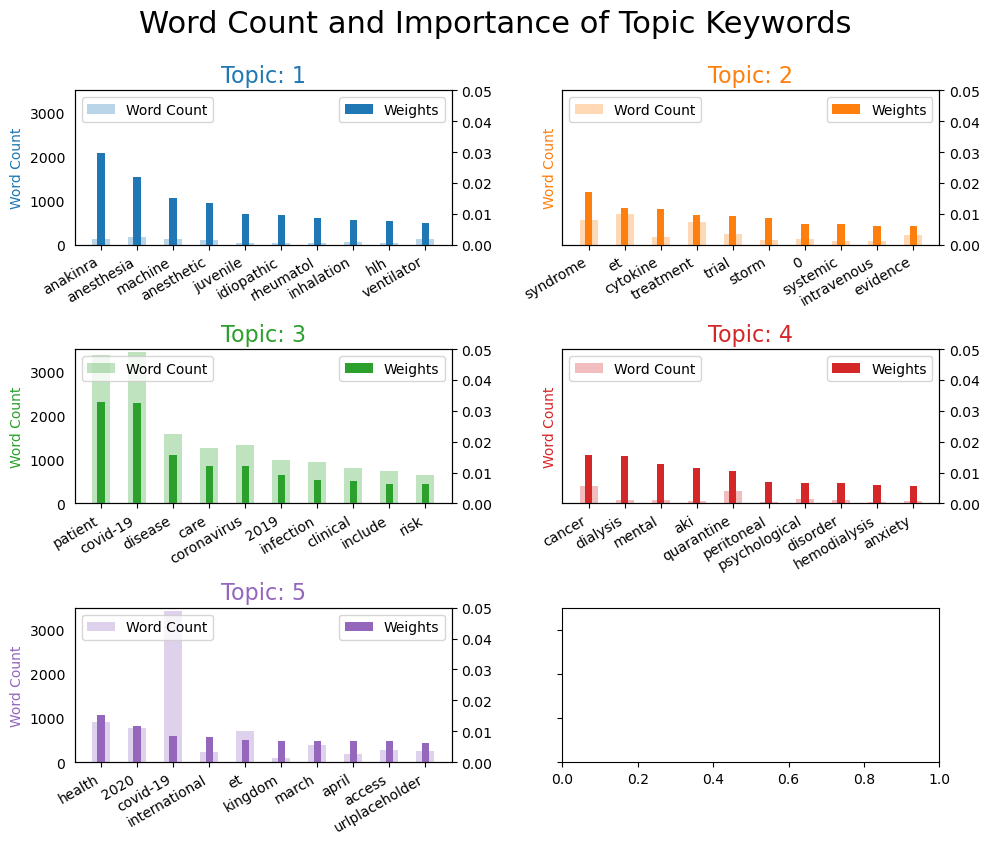

In [149]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_for_topics for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(10,8), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()[0:-1]):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.050); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [152]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.344054  0.064777       1        1  62.627445
4      0.002348  0.025444       2        1  16.222897
1      0.037440 -0.289689       3        1  15.756285
3      0.105147  0.070713       4        1   3.102312
0      0.199119  0.128755       5        1   2.291061, topic_info=                Term         Freq        Total Category  logprob  loglift
147          patient  3589.000000  3589.000000  Default  30.0000  30.0000
987           cancer   425.000000   425.000000  Default  29.0000  29.0000
92          syndrome   769.000000   769.000000  Default  28.0000  28.0000
34          covid-19  3790.000000  3790.000000  Default  27.0000  27.0000
129           health  1030.000000  1030.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
4336      ventilator    28.254169   128.001923   Topic5  -4.9555   2.2654
6000          oxford    12.693424    20.618824   Topic5  -5.7557   3.2910
1483         achieve    14.613065    37.553928   Topic5  -5.6148   2.8323
511   hemophagocytic    15.286369    95.750107   Topic5  -5.5698   1.9414
556              per    14.010965   100.557983   Topic5  -5.6569   1.8053

[278 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
3026       2  0.215152            0
3026       3  0.780455            0
0          1  0.517235            1
0          3  0.479389            1
1          1  0.650800            2
...      ...       ...          ...
4336       5  0.218747   ventilator
14137      5  0.906808     volatile
2561       2  0.994798    volunteer
11969      5  0.922244           vs
17659      5  0.932213  weightsclin

[349 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

# Trends for keywords

In [215]:
data_processed['week'] = data_processed['PublishedDate'].apply(lambda x: x.week() if x != None else None)

AttributeError: 'datetime.date' object has no attribute 'week'

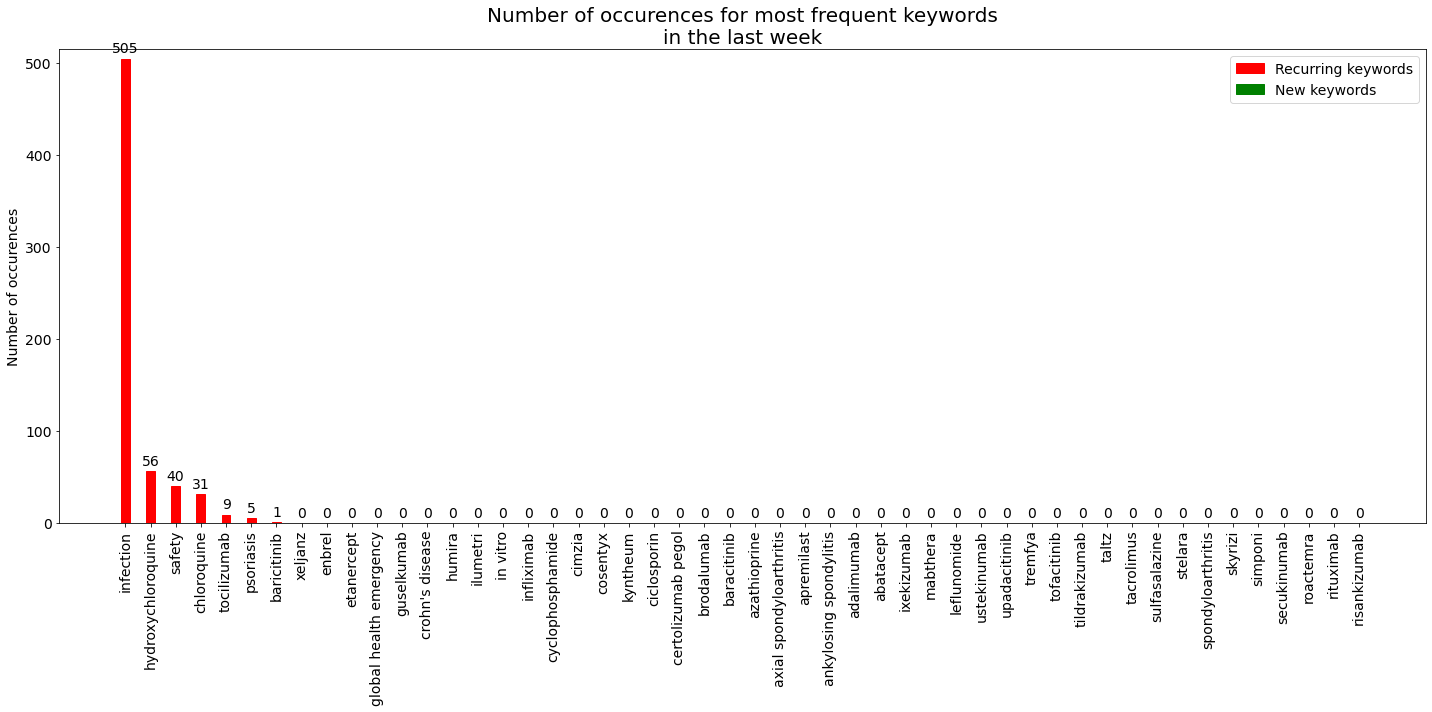

In [257]:
#number of keywords to show:
n = 50

t = (datetime.today() - timedelta(days=7)).date()
after = data_processed[data_processed.PublishedDate >= t]
before = data_processed[data_processed.PublishedDate < t]
after = after.iloc[:,after.columns.get_loc(keywords[0]):].sum()
before = before.iloc[:,before.columns.get_loc(keywords[0]):].sum()
after.sort_values(ascending=False, inplace=True)

recurring_entities = []
for keyword in after.index:
    if keyword in before.index:
        recurring_entities.append(keyword)

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
terms = after.index[0:n]
counts = after[0:n]

x = np.arange(len(terms))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x, counts, width)

for i in range(0,len(terms)):
    if terms[i] in recurring_entities:
        rects1[i].set_color('r')
    else:
        rects1[i].set_color('g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of occurences', fontsize=14)
ax.set_title('Number of occurences for most frequent keywords\nin the last week', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(terms)
ax.set_ylim([0, max(counts)+10])
ax.tick_params(labelsize=14)
plt.xticks(rotation=90) 

red_patch = mpatches.Patch(color='red', label='Recurring keywords')
green_patch = mpatches.Patch(color='green', label='New keywords')
plt.legend(handles=[red_patch,green_patch],fontsize=14)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=14)


autolabel(rects1)

fig.tight_layout()

plt.show()

In [262]:
evolution = data_processed
    
evolution = evolution.groupby(['PublishedDate'],as_index=True)[keywords].sum()
evolution.sort_values(by='PublishedDate', inplace=True)
evolution = evolution.T

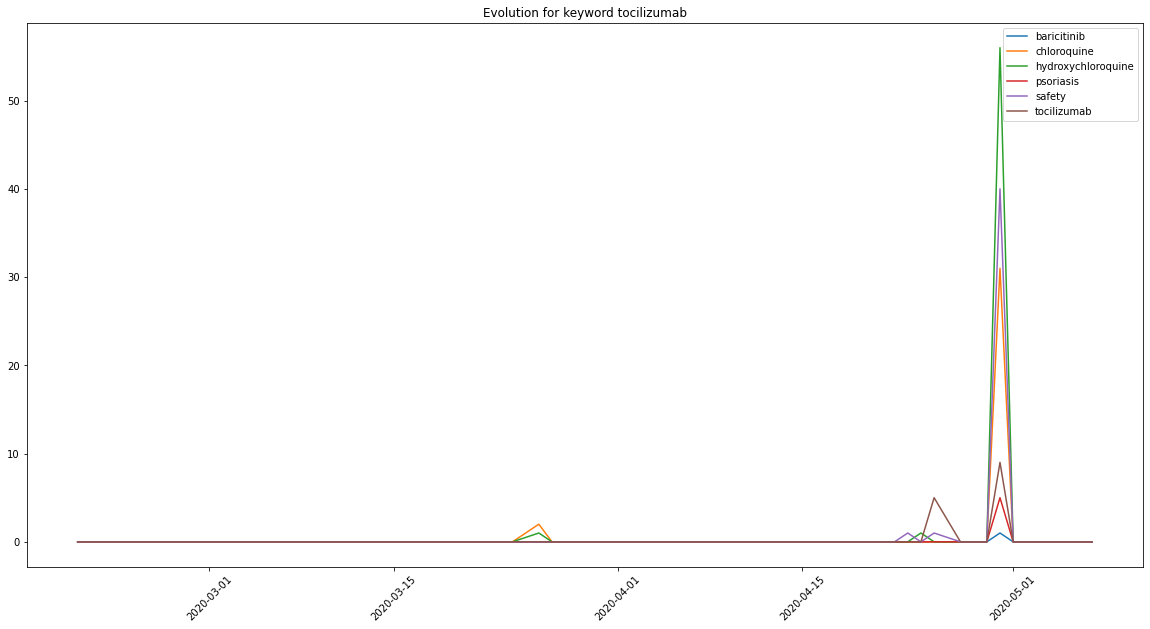

In [288]:
fig, ax = plt.subplots(figsize=(20,10))
l = []

for keyword in keywords:
    if (evolution.loc[evolution.index==keyword,:].sum(axis=1) == 0).all():
        continue
    if keyword == 'infection':
        continue
    plt.plot(evolution.columns,evolution[evolution.index==keyword].T)
    plt.xticks(rotation=45)
    plt.title('Evolution for keyword '+keyword)
    l.append(keyword)
plt.legend(l)

## Network

In [292]:
adj = data_processed[['ID','abstract_words']]

for keyword in keywords:
    adj[keyword] = adj['abstract_words'].apply(lambda x: x.count(keyword) if (keyword in x)
                                                         else 0)
    
adj = adj.groupby(['ID'],as_index=True)[keywords].sum()
adj = adj.T
adj.sort_index(inplace=True)
display(adj.shape)

c:\python_3.7.4\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(63, 197)

In [293]:
#adjacency matrix of keywords based on publications
A = np.dot(adj,adj.T)
adj = pd.DataFrame(A, index=adj.index, columns=adj.index)
display(adj[adj>=1])

,SARS-CoV-2,abatacept,adalimumab,ankylosing spondylitis,apremilast,axial spondyloarthritis,axial spondyloarthritis,azathioprine,baracitinib,baricitinib,...,sulfasalazine,tacrolimus,taltz,tildrakizumab,tocilizumab,tofacitinib,tremfya,upadacitinib,ustekinumab,xeljanz
SARS-CoV-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abatacept,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN
adalimumab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ankylosing spondylitis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apremilast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tofacitinib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
tremfya,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
upadacitinib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ustekinumab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


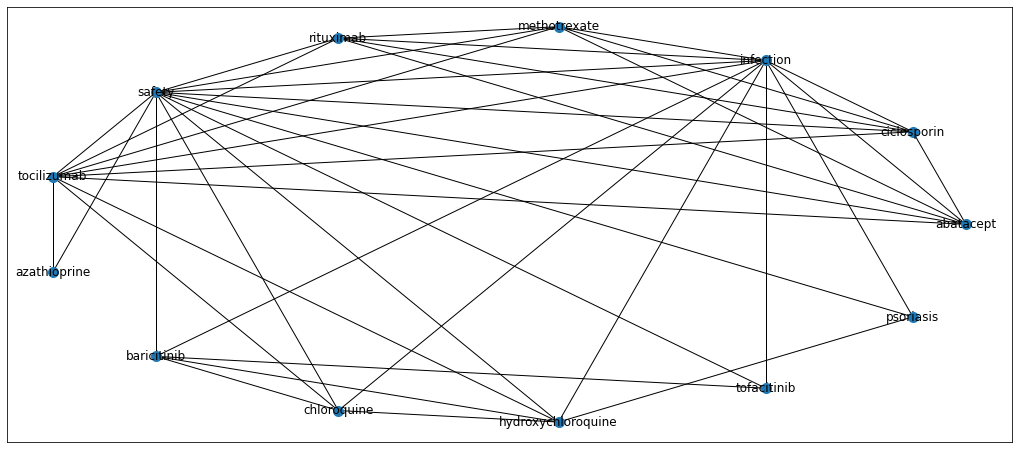

In [296]:
rows, cols = np.where(A >= 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
matching = {x : adj.index.values[x] for x in range(len(adj.index))} 
gr = nx.relabel_nodes(gr,matching)
graph_pos=nx.circular_layout(gr)
plt.figure(figsize=(18,8)) 
nx.draw_networkx_nodes(gr,graph_pos,node_size=100)
nx.draw_networkx_edges(gr,graph_pos)
nx.draw_networkx_labels(gr, graph_pos)
plt.show()
    